In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import json
from itertools import product

In [2]:
def imshow(image, label=None, figsize=(4,4), cmap='gray', **kwargs):
    plt.figure(figsize=figsize)
    if label is not None:
        print(label)
    plt.imshow(image, **kwargs, cmap=cmap)
    plt.show()

In [3]:
class Flatten:
    def __call__(self, img):
        return img.flatten()

# Data

In [4]:
N = 28
NUM_CLASSES = 10
SEED = 42

In [5]:
transforms = torchvision.transforms.Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,)),
    Flatten(),
])

In [6]:
train_dataset = datasets.MNIST(root='../data', train=True, download=False, transform=transforms)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [7]:
test_dataset = datasets.MNIST(root='../data', train=False, download=False, transform=transforms)
# test_loader = DataLoader(Subset(test_dataset, np.arange(1_000)), batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
for img, label in test_loader:
    break

7


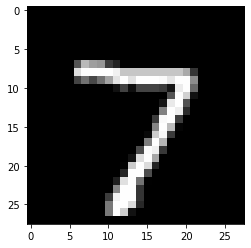

In [9]:
imshow(img[0].reshape(N, N), label=label[0].item())

# Activations

In [10]:
class Tanh():
    def forward(self, x):
        self.old_y = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
        return self.old_y
    
    def backward(self, grad):
        return (1 - self.old_y**2) * grad

In [11]:
class Sigmoid():
    def forward(self, x):
        self.old_y = np.exp(x) / (1. + np.exp(x))
        return self.old_y

    def backward(self, grad):
        return self.old_y * (1. - self.old_y) * grad

In [12]:
class ReLU():
    def forward(self, x):
        self.old_x = np.copy(x)
        return np.clip(x,0,None)

    def backward(self, grad):
        return np.where(self.old_x>0,grad,0)

In [13]:
class Softmax():
    def forward(self,x):
        self.old_y = np.exp(x) / np.exp(x).sum(axis=1)[:,None]
        return self.old_y

    def backward(self,grad):
        return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

# Costs

In [14]:
class MSE():
    def forward(self, x, y):
        self.old_x = x
        self.old_y = y
        return (1/2 * np.square(x-y)).mean()
    
    def backward(self):
        return (self.old_x - self.old_y).mean(axis=0)

In [15]:
class CrossEntropy():
    def forward(self,x,y):
        self.old_x = x.clip(min=1e-10,max=None)
        self.old_y = y
        return (np.where(y==1,-np.log(self.old_x), 0)).mean()

    def backward(self):
        return np.where(self.old_y==1,-1/self.old_x, 0).mean(axis=0)

# Net layer

In [16]:
class Linear():
    def __init__(self,n_in,n_out):
        self.w = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
        self.b = np.zeros(n_out)

    def forward(self, x):
        self.old_x = x
        return np.dot(x,self.w) + self.b

    def backward(self,grad):
        self.grad_b = grad.mean(axis=0)
        self.grad_w = self.old_x.T @ grad
        return np.dot(grad, self.w.T)

# Optimizer

In [17]:
class SGD():
    def __init__(self, lr=0.01, l1=0, l2=0):
        self.lr = lr
        self.l1 = l1
        self.l2 = l2

    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]

    def step(self):
        for layer in self.layers:
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            layer.w -= self.lr * layer.grad_w
            layer.b -= self.lr * layer.grad_b

In [18]:
class Momentum():
    def __init__(self, lr=0.01, momentum=0.6, l1=0, l2=0):
        self.m = momentum
        self.lr = lr
        self.l1 = l1
        self.l2 = l2
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * layer.grad_b
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]

In [19]:
class Nesterov():
    def __init__(self, lr=0.01, momentum=0.6, l1=0, l2=0):
        self.m = momentum
        self.lr = lr
        self.l1 = l1
        self.l2 = l2
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.velocity_w = []
        self.velocity_b = []
        for l in self.layers:
            self.velocity_w.append(np.zeros_like(l.w))
            self.velocity_b.append(np.zeros_like(l.b))
        
    def step(self):
        model_ahead =  deepcopy(self.model)
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        
        for i, layer in enumerate(ahead_layers):
            layer.w -= self.m * self.velocity_w[i] 
            layer.b -= self.m * self.velocity_b[i]
        
        
        model_ahead.loss(self.model.cur_x, self.model.cur_y)
        model_ahead.backward()
        
        ahead_layers = [l  for l in model_ahead.layers if type(l) == Linear]
        
        for i, (ahead_layer, layer) in enumerate(zip(ahead_layers, self.layers)):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            self.velocity_w[i] = self.m * self.velocity_w[i] + self.lr * ahead_layer.grad_w
            self.velocity_b[i] = self.m * self.velocity_b[i] + self.lr * ahead_layer.grad_b
            
            layer.w -= self.velocity_w[i]
            layer.b -= self.velocity_b[i]

In [20]:
class AdaGrad():
    def __init__(self, lr=1, l1=0, l2=0):
        self.lr = lr
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            self.N_w[i] += layer.grad_w ** 2 
            self.N_b[i] += layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)

In [21]:
class RMSprop():
    def __init__(self, lr=0.01, decay=0.9, l1=0, l2=0):
        self.lr = lr
        self.decay = decay
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
        
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
   
    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            self.N_w[i] = self.decay * self.N_w[i] + (1-self.decay) * layer.grad_w ** 2
            self.N_b[i] = self.decay * self.N_b[i] + (1-self.decay) * layer.grad_b ** 2
            
            layer.w -= self.lr * layer.grad_w / (np.sqrt(self.N_w[i]) + self.eps)
            layer.b -= self.lr * layer.grad_b / (np.sqrt(self.N_b[i]) + self.eps)

In [22]:
class AdaDelta():
    def __init__(self, lr=0.01, decay=0.9, l1=0, l2=0):
        self.lr = lr
        self.decay = decay
        self.l1 = l1
        self.l2 = l2
        self.eps = 1e-10
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
        
        self.N_w = []
        self.N_b = []
        
        self.P_w = []
        self.P_b = []
        for l in self.layers:
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
            self.P_w.append(np.zeros_like(l.w))
            self.P_b.append(np.zeros_like(l.b))
            

    def step(self):
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            self.N_w[i] = self.decay * self.N_w[i] + (1-self.decay)*layer.grad_w ** 2 
            self.N_b[i] = self.decay * self.N_b[i] + (1-self.decay)*layer.grad_b ** 2

            d_w = layer.grad_w * np.sqrt(self.P_w[i] + self.eps) / np.sqrt(self.N_w[i] + self.eps)
            d_b = layer.grad_b * np.sqrt(self.P_b[i] + self.eps) / np.sqrt(self.N_b[i] + self.eps)

            self.P_w[i] = self.decay * self.P_w[i] + (1 - self.decay) * d_w ** 2
            self.P_b[i] = self.decay * self.P_b[i] + (1 - self.decay) * d_b ** 2
            layer.w -= self.lr * d_w
            layer.b -= self.lr * d_b

In [23]:
class Adam():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

In [24]:
class AdaMax():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b


            self.N_w[i] = max(self.beta2 * self.N_w[i], abs(layer.grad_w) + self.eps, key=np.linalg.norm)
            self.N_b[i] = max(self.beta2 * self.N_b[i], abs(layer.grad_b) + self.eps, key=np.linalg.norm)
            

            layer.w -= self.lr * self.M_w[i] / (self.N_w[i] * (1 - self.beta1 ** t))
            layer.b -= self.lr * self.M_b[i] / (self.N_b[i] * (1 - self.beta1 ** t))

In [25]:
class NAdam():
    def __init__(self, lr=0.002, beta1=0.9, beta2=0.999, momentum_decay=0.004, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.momentum_decay = momentum_decay
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        self.N_w = []
        self.N_b = []
        self.mus = []
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)
            
            mu = self.beta1 * (1 - 0.5 * 0.96**((t)*self.momentum_decay))
            mu_n = self.beta1 * (1 - 0.5 * 0.96**((t+1)*self.momentum_decay))
            
            self.mus.append(mu)
            
            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b
            
            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            m_w_hat = mu_n*self.M_w[i] / (1-np.prod(self.mus + [mu_n])) - (1-mu)*layer.grad_w / (1-np.prod(self.mus))   
            m_b_hat = mu_n*self.M_b[i] / (1-np.prod(self.mus + [mu_n])) - (1-mu)*layer.grad_b / (1-np.prod(self.mus))   
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)
            
            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)


In [26]:
class AMSGrad():
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, l1=0, l2=0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-10
        self.l1 = l1
        self.l2 = l2
    
    def init_params(self, model):
        self.model = model
        self.layers = [l  for l in model.layers if type(l) == Linear]
                
        self.M_w = []
        self.M_b = []
        
        self.N_w = []
        self.N_b = []
        self.prev_n_w_hat = 0
        self.prev_n_b_hat = 0
        for l in self.layers:              
            self.M_w.append(np.zeros_like(l.w))
            self.M_b.append(np.zeros_like(l.b))
            
            self.N_w.append(np.zeros_like(l.w))
            self.N_b.append(np.zeros_like(l.b))
            
   
    def step(self):
        t = self.model.cur_epoch + 1
        for i, layer in enumerate(self.layers):
            layer.grad_w += self.l1 * layer.w + self.l2 * np.sign(layer.w)

            self.M_w[i] = self.beta1 * self.M_w[i] + (1 - self.beta1) * layer.grad_w
            self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * layer.grad_b

            self.N_w[i] = self.beta2 * self.N_w[i] + (1 - self.beta2) * layer.grad_w ** 2
            self.N_b[i] = self.beta2 * self.N_b[i] + (1 - self.beta2) * layer.grad_b ** 2
            
            
            m_w_hat = self.M_w[i] / (1 - self.beta1 ** t)
            m_b_hat = self.M_b[i] / (1 - self.beta1 ** t)
            
            n_w_hat = self.N_w[i] / (1 - self.beta2 ** t)
            n_b_hat = self.N_b[i] / (1 - self.beta2 ** t)


            layer.w -= self.lr * m_w_hat / (np.sqrt(n_w_hat) + self.eps)
            layer.b -= self.lr * m_b_hat / (np.sqrt(n_b_hat) + self.eps)

# Model 

In [54]:
class Model():
    def __init__(self, layers, cost, optimizer):
        self.layers = layers
        self.cost = cost
        self.optimizer = optimizer
        self.optimizer.init_params(self)
        
    def one_hot(self, label):
        return np.eye(10)[label]
    
    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x), y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
    
    def train(self, train_loader, test_loader, epochs, num_samples=10_000, verbose=True):
        samples = 0
        accs = []
        losses = []
        for epoch in tqdm(range(epochs)):
            self.cur_epoch = epoch
            for img, label in train_loader:
                bs = img.shape[0]
                y = self.one_hot(label)
                x = img.numpy()
                self.cur_x = x
                self.cur_y = y

                self.loss(x, y)
                self.backward()

                self.optimiSzer.step()
                
#                 samples += bs
#                 if samples > num_samples:
#                     break
            
            acc, loss = self.validate(test_loader)
            if verbose:
                print(f"epoch: {epoch}")
                print(f"loss: {loss} acc: {acc}")
            accs.append(acc)
            losses.append(loss)
        return accs, losses
    
    def validate(self, loader):
        losses = []
        acc = 0
        counter = 0
        for img, label in loader:
            bs = img.shape[0]
            y = self.one_hot(label)
            x = img.numpy()
            
            preds = np.argmax(np.array(self.forward(x)), axis=1)
            labels = label.numpy()
            
            acc += sum(labels == preds)
            counter += bs
            
            losses.append(self.loss(x, y))
        return acc / counter, np.mean(losses)

In [59]:
EPOCHS = 20
LR = 0.002

In [44]:
OPTIMIZERS = [
    SGD(LR),
    Momentum(LR, momentum=0.6),
    Nesterov(LR, momentum=0.6),
    AdaGrad(LR),
    AdaDelta(lr=1),
    RMSprop(LR, decay=0.9),
    Adam(LR, beta1=0.9, beta2=0.99)
]

# 1. train val error

In [91]:
TRAIN_SIZES = [0.2, 0.4, 0.6, 0.8, 1]

In [92]:
TOTAL_TRAIN = len(train_dataset)

In [93]:
TOTAL_TRAIN

60000

In [94]:
TOTAL_TEST = len(test_dataset)

In [95]:
TOTAL_TEST / (TOTAL_TRAIN + TOTAL_TEST)

0.14285714285714285

In [96]:
EPOCHS = 20
LR = 0.001

In [97]:
config = {
    'layers': [Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()], 
    'cost': MSE(),
    'optimizer': Adam(LR),
}

In [122]:
from collections import namedtuple
Exp = namedtuple('exp', 'name, acc, loss')

In [100]:
experiments = []
for ts in TRAIN_SIZES:
    train_loader = DataLoader(
        Subset(train_dataset, np.arange(TOTAL_TRAIN * ts, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
    )
    model = Model(**config)
    acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
    name = f'{round(ts*100)}%'
    experiments.append(Exp(name, acc, loss))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

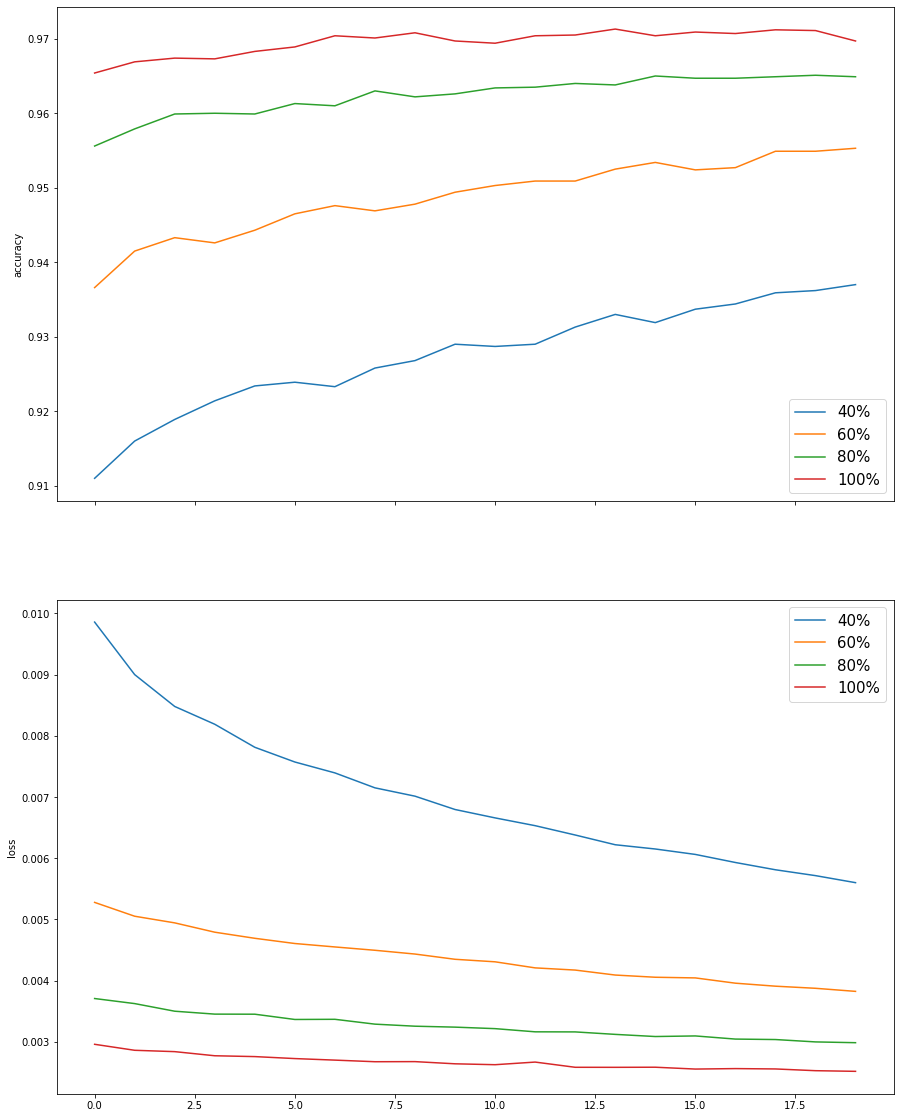

In [137]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 20), sharex=False)
names = [exp.name for exp in experiments[START_IDX:]]
START_IDX = 1
for exp in experiments[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

### 1.1 save results

In [60]:
to_save = [json.dumps(exp._asdict()) for exp in experiments]
with open('train_exps2.json', 'w') as f:
    json.dump(to_save, f)

### 1.2 load results

In [121]:
with open('train_exps.json', 'r') as f:
    loaded_exps = [Exp(**eval(d)) for d in json.load(f)]

In [123]:
Exp('a', [1], [2])

exp(name='a', acc=[1], loss=[2])

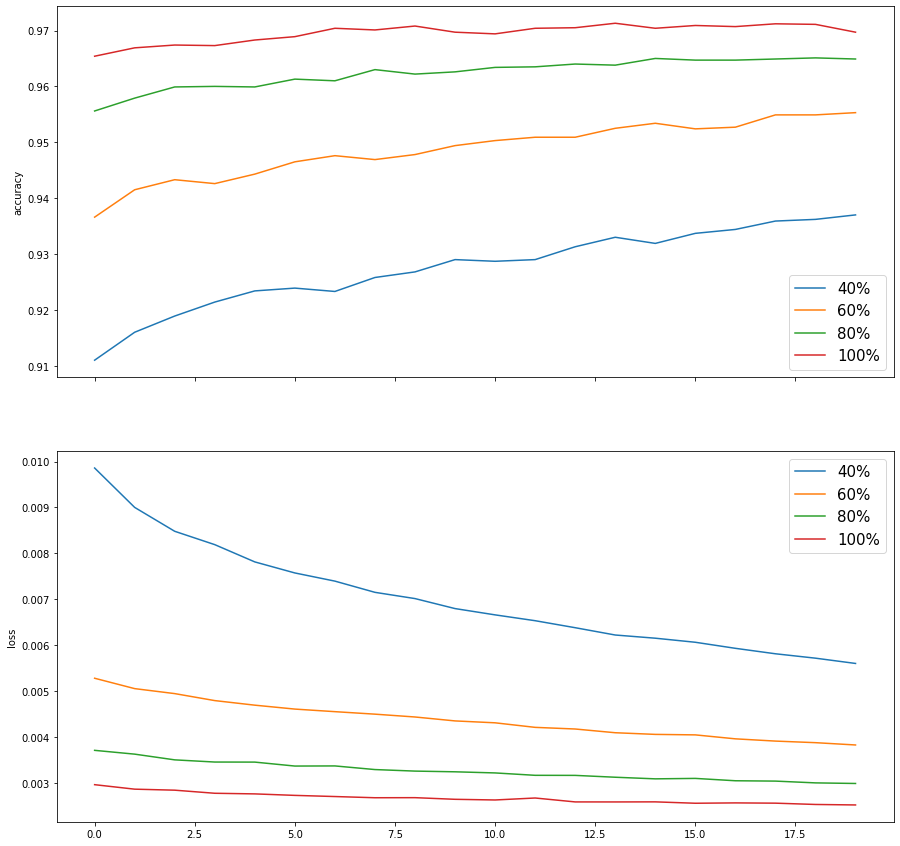

In [138]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 1
names = [exp.name for exp in loaded_exps[START_IDX:]]
for exp in loaded_exps[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

# 2. Model capacity

In [155]:
archs = {
    0: [Linear(784, 10), Sigmoid()],
    1: [Linear(784, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
    2: [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
    3: [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()],
}

In [156]:
capacity_exps = []
train_loader = DataLoader(
    Subset(train_dataset, np.arange(TOTAL_TRAIN * 0.5, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
)
for name, arch in archs.items():
    model = Model(
        layers=arch,
        cost=MSE(),
        optimizer=Adam(LR),
    )
    acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
    capacity_exps.append(Exp(name, acc, loss))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

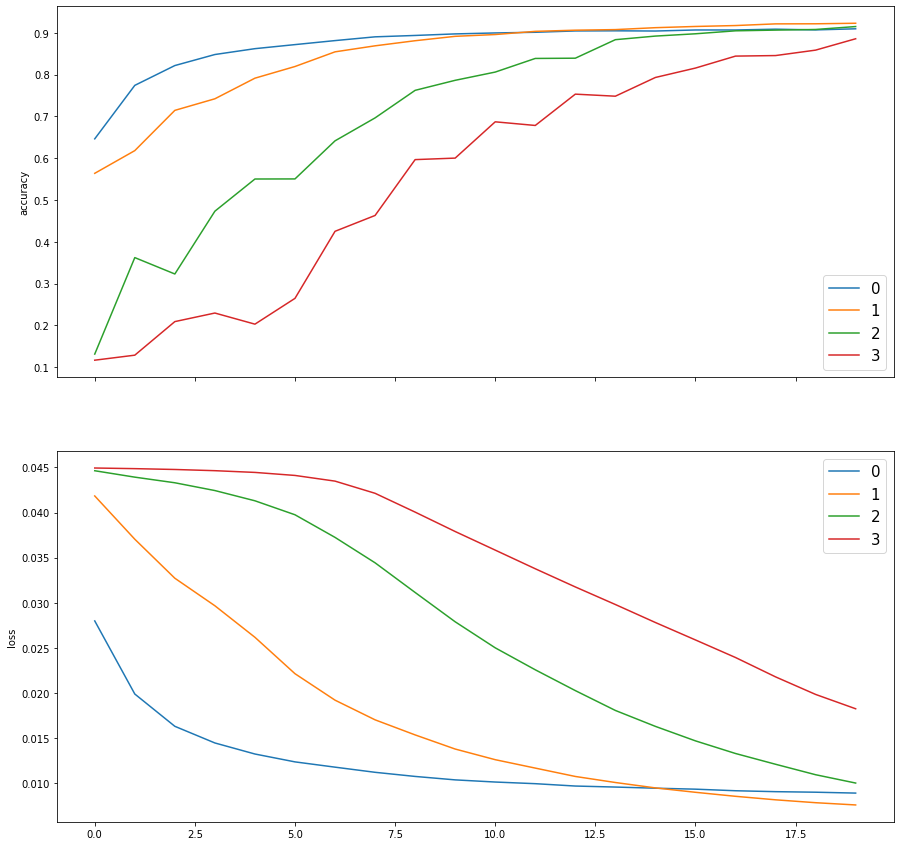

In [157]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in capacity_exps[START_IDX:]]
for exp in capacity_exps[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

In [158]:
to_save = [json.dumps(exp._asdict()) for exp in capacity_exps]
with open('capacity_exps.json', 'w') as f:
    json.dump(to_save, f)

In [160]:
for e in capacity_exps:
    print(f'max accuracy for {e.name} layers: {max(e.acc)}')

max accuracy for 0 layers: 0.9095
max accuracy for 1 layers: 0.9228
max accuracy for 2 layers: 0.9149
max accuracy for 3 layers: 0.8857


best option: 1-2 hidden layer

# 3. Regularization

In [214]:
l2s = [0.01, 0.001, 0.0001, 0]
l1s = [0.01, 0.001, 0]
EPOCHS = 50

In [215]:
regularization_exrps = []
train_loader = DataLoader(
    Subset(train_dataset, np.arange(TOTAL_TRAIN * 0.5, dtype=int)), batch_size=BATCH_SIZE, shuffle=True,
)
for l1, l2 in product(l1s, l2s):
    name = f'l1: {l1}, l2: {l2}'
    model = Model(
        layers=[Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Softmax()],
        cost=MSE(),
        optimizer=Adam(LR),
    )
    acc, loss = model.train(train_loader, test_loader, epochs=EPOCHS, verbose=0)
    print(f'{name} acc: {max(acc)}')
    regularization_exrps.append(Exp(name, acc, loss))

  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.01, l2: 0.01 acc: 0.9653


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.01, l2: 0.001 acc: 0.9687


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.01, l2: 0.0001 acc: 0.9664


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.01, l2: 0 acc: 0.9677


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.001, l2: 0.01 acc: 0.9663


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.001, l2: 0.001 acc: 0.9685


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.001, l2: 0.0001 acc: 0.9685


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0.001, l2: 0 acc: 0.9664


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0, l2: 0.01 acc: 0.9677


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0, l2: 0.001 acc: 0.965


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0, l2: 0.0001 acc: 0.9668


  0%|          | 0/50 [00:00<?, ?it/s]

l1: 0, l2: 0 acc: 0.9664


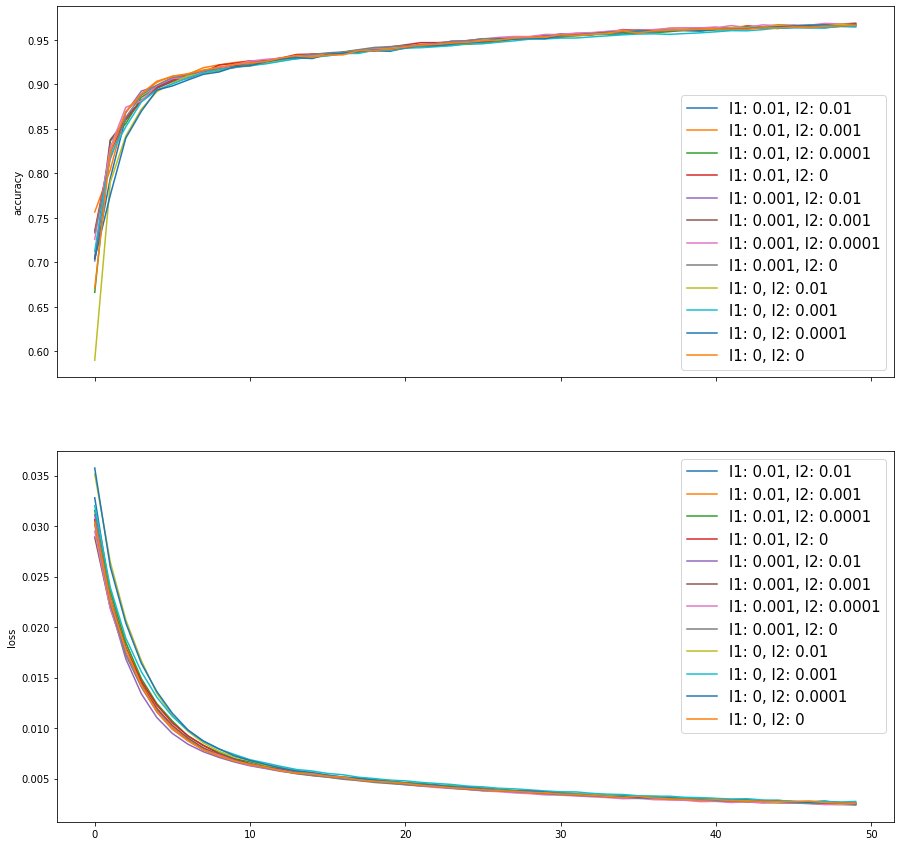

In [216]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in regularization_exrps[START_IDX:]]
for exp in regularization_exrps[START_IDX:]:
    axs[0].plot(exp.acc)
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss)
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()

In [218]:
to_save = [json.dumps(exp._asdict()) for exp in regularization_exrps]
with open('regulatization_exps.json', 'w') as f:
    json.dump(to_save, f)

In [219]:
best = ('a', 0)
for e in regularization_exrps:
    m = max(e.acc)
    n = e.name
    if m > best[1]:
        best = (n, m)
    print(f'acc for\t {n}: \t\t {m}')
print('-'*20)
print(f'overall best: {best}')

acc for	 l1: 0.01, l2: 0.01: 		 0.9653
acc for	 l1: 0.01, l2: 0.001: 		 0.9687
acc for	 l1: 0.01, l2: 0.0001: 		 0.9664
acc for	 l1: 0.01, l2: 0: 		 0.9677
acc for	 l1: 0.001, l2: 0.01: 		 0.9663
acc for	 l1: 0.001, l2: 0.001: 		 0.9685
acc for	 l1: 0.001, l2: 0.0001: 		 0.9685
acc for	 l1: 0.001, l2: 0: 		 0.9664
acc for	 l1: 0, l2: 0.01: 		 0.9677
acc for	 l1: 0, l2: 0.001: 		 0.965
acc for	 l1: 0, l2: 0.0001: 		 0.9668
acc for	 l1: 0, l2: 0: 		 0.9664
--------------------
overall best: ('l1: 0.01, l2: 0.001', 0.9687)


In [220]:
with open('regulatization_exps.json', 'r') as f:
    loaded_exps = [Exp(**eval(d)) for d in json.load(f)]

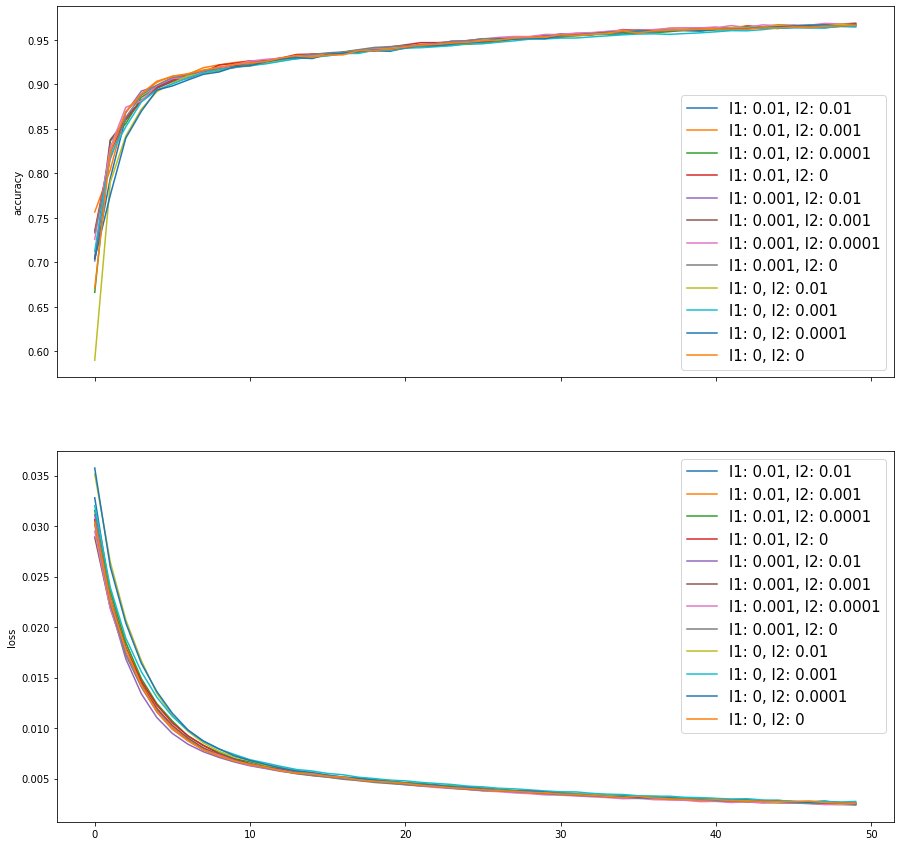

In [222]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 15), sharex=True)
START_IDX = 0
names = [exp.name for exp in loaded_exps[START_IDX:]]
for exp in loaded_exps[START_IDX:]:
    axs[0].plot(exp.acc[:])
    axs[0].set(ylabel='accuracy')
    axs[1].plot(exp.loss[:])
    axs[1].set(ylabel='loss')
    
axs[0].legend(names, prop={'size': 15})
axs[1].legend(names, prop={'size': 15})

for ax in axs.flat:
    ax.label_outer()